#### Feature Extraction 

- This is a file containing the methods for feature extraction from melanoma images.
We mainly focus on 
1. color
2. texture
3. irregularity
4. assymetry 
of symptom

- I break down the steps into functions. Those interested in final image processing can skip to the **Test Image with sample code** section in the outline :) to save time.

#### Used Packages 

In [37]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import imutils
import skimage.feature as feature
import os
import argparse
import warnings
warnings.filterwarnings("ignore")
from  pandas.core.frame import DataFrame

#### Step0: Locate the center point of the pic 

In [38]:
def step0_direction(img, path_values, path, index) :
    
    ''' 
    param: 
        img: ndarray
        path_values: list
        path: list 
        index: 
    output: 

    '''
    
    # 取得圖片中心點
    height, width = img.shape
    height = int(height)
    width = int(width)
    max_ = 50

    # 計算圖片尺寸，以此作為前進的步
    h = int(height/(max_*2))
    w = int(width/(max_*2))
    
    # 前進方向（左上、右上、左下、右下）
    directions = [[-h, -w], [-h, w], [h, -w], [h, w]]
    x = int(height/2)
    y = int(width/2)
    for i in range(int(max_)):
        path.append((x, y))
        path_values.append(img[x, y])
        x += directions[index][0]
        y += directions[index][1]
        if not (0 <= x < height and 0 <= y < width):
            break
    # print('往', direction, '方向的路徑：', path)

def step0_findpoint(path_values):
    n = np.array(path_values).shape[0]
    path_values = np.array(path_values)
    count=0
    for i in range(n-1,0,-1):
        if path_values[i]==1:
            count=count+1
        else:
            break
    return count


#### Step1: Remove Hair
- Apply morphological closing (閉操作)
    - First dilation(膨脹), then erosion(腐蝕)
    - Fill in tiny black regions and connect the broken parts. 

In [39]:
def step1_removehair(filename):
    '''  
    param: filepath: str
    output: (original picture, removedhair picture): tuple
    '''
    img_ori = cv2.imread(filename,1)
    if img_ori[0][0][0] == 255 :
        for i in range(0,img_ori.shape[0],1) :
            for j in range(0,img_ori.shape[1],1) :
                if img_ori[i][j][0] == 255 and  img_ori[i][j][1] == 255 and img_ori[i][j][2] == 255:
                    img_ori[i][j][0] = 0
                    img_ori[i][j][1] = 0
                    img_ori[i][j][2] = 0
# cv2.getStructuringElement()来生成不同形状的结构元素  
    kernel3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (10, 5)) # 十字结构
#第二和第三个参数分别是内核的尺寸以及锚点的位置

    # 使用不同结构元素  执行闭操作
    closing3 = cv2.morphologyEx(img_ori, cv2.MORPH_CLOSE, kernel3)
    return (img_ori,closing3)

#### Step2: Binarization 
- Binarize picture by **OTSU algorithm**

In [40]:
def step2_binary(img_removehair):

    '''   
    param: removed hair picture : numpy.ndarray
    output: numpy.ndarray
    '''

    im2 = np.mean(img_removehair,axis=2)
    blur = cv2.GaussianBlur(im2,(3,3),0)
    blur = blur.astype("uint8")
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #二值化
    img_bin = np.where(im2 >= ret3,0, 1)
    return img_bin


#### Step3: Morphological Opening (開操作)
- First erosion(腐蝕), then dilation(膨脹) 
- Remove small bright areas and separate connected objects.

In [41]:
def step3_fill(img_binary):

    '''     
    param: binarizied picture : numpy.ndarray
    output: numpy.ndarray
    '''

    img_binary = img_binary.astype('uint8')
    #cv2.getStructuringElement()来生成不同形状的结构元素
    kernel3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20)) # 十字结构
    #使用不同结构元素  执行开操作
    opening3 = cv2.morphologyEx(img_binary , cv2.MORPH_OPEN, kernel3)
    
    return opening3

#### Step4: calculate the numbers of contours in the picture

In [42]:
def step4_contour(img_original,img_open):
    
    black1 = np.zeros(img_original.shape, np.uint8)  
    white1 = np.ones(img_original.shape, np.uint8) * 255 
    (contours,hierarchy)=cv2.findContours(img_open.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    l_im = list(contours)
    l_im.sort(key=len, reverse=True)
    max_con  = cv2.drawContours(white1,[l_im[0]],-1,(0,0,255),2)
    #如果要改背景，改第一位置的參數
    return (max_con,l_im)

#### Step5: Draw the smallest rectangle around each contour

In [43]:
def step5_rec(img_maxcon,list_con):
    img_copy = np.copy(img_maxcon)
    rect = cv2.minAreaRect(list_con[0])
    box = cv2.cv.Boxpoints() if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_copy, [box], 0, (0, 0, 255), 2)

    #算矩形面積

    side1=math.sqrt((box[0][0]-box[1][0])**2+(box[0][1]-box[1][1])**2)
    side2=math.sqrt((box[1][0]-box[2][0])**2+(box[1][1]-box[2][1])**2)
    area_rect=side1*side2
    
    return (area_rect,box,img_copy)

#### Step6: Draw the smallest ellipse around each contour

In [44]:
def step6_ell(list_con,img_copy):
    
    ellipse = cv2.fitEllipse(list_con[0])
    cv2.ellipse(img_copy, ellipse, (255, 0, 255), 2)
    ellipse_center = (int(ellipse[0][0]), int(ellipse[0][1]))  # 椭圆圆心坐标
    cv2.circle(img_copy, ellipse_center, 1, (255, 0, 255), 2)
    #cv2.waitKey(0)
    #算橢圓面積
    area_ell=(ellipse[1][0]/2)*(ellipse[1][1]/2)*3.1415926
    return (area_ell,img_copy)

#### Step7: Calculate the area of interested symptoms

In [45]:
def step7_area_m(list_con,area_ell,area_rect):
    area_m=0
    for i in list_con:
        area_m += cv2.contourArea(i)
    ae_diff = abs(area_m - area_ell)/area_m
    ar_diff = abs(area_m - area_rect)/area_m
    return (area_m,ae_diff,ar_diff)

#### Step8: Calculate the area of whole picture

In [46]:
def step8_area_img(img_original):
    sp = img_original.shape
    sp1 = sp[0]#height(rows) of image
    sp2 = sp[1]#width(colums) of image
    sp3 = sp[2]#the pixels value is made up of three primary colors
    area_sp = sp1 * sp2
    return area_sp

#### Step9: Measuring the symptoms area percentage in the original picture

In [47]:
def step9_prop(area_m,area_sp):
    Proportion = area_m / area_sp
    return Proportion

#### Step10

In [48]:
def step10_mask(closing3,box):
    rows=closing3.shape[0]
    cols=closing3.shape[1]
    channels=closing3.shape[2]
    mask=np.zeros(closing3.shape,dtype=np.uint8)
#输入点的坐标
    roi_corners=np.array([[box[0],box[1],box[2],box[3]]],dtype=np.int32)
    channel_count=channels
    ignore_mask_color = (255,)*channel_count
#创建mask层
    cv2.fillPoly(mask,roi_corners,ignore_mask_color)
#为每个像素进行与操作，除mask区域外，全为0
    masked_image=cv2.bitwise_and(closing3,mask)
    #cv2.waitKey(0)
    return masked_image

#### Step11: 

In [49]:
# 计算方位角函数
def step11_angle( x1,  y1,  x2,  y2):
    angle = 0.0;
    dx = x2 - x1
    dy = y2 - y1
    if  x2 == x1:
        angle = math.pi / 2.0
        if  y2 == y1 :
            angle = 0.0
        elif y2 < y1 :
            angle = 3.0 * math.pi / 2.0
    elif x2 > x1 and y2 > y1:
        angle = math.atan(dx / dy)
    elif  x2 > x1 and  y2 < y1 :
        angle = math.pi / 2 + math.atan(-dy / dx)
    elif  x2 < x1 and y2 < y1 :
        angle = math.pi + math.atan(dx / dy)
    elif  x2 < x1 and y2 > y1 :
        angle = 3.0 * math.pi / 2.0 + math.atan(dy / -dx)
    return (angle * 180 / math.pi)

#### Step12: Rotate image

In [50]:
def step12_rotate(masked_image,angle):
# 对图像进行旋转
    rotated = imutils.rotate_bound(masked_image, angle-90)
    return rotated

#### Step13: Binarization

In [51]:
def step13_binary(rotated):
    im3 = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    otsu_threshold, image_result = cv2.threshold(im3, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
    
    #二值化
    img_binary_fac = np.where(im3 >= otsu_threshold,1, 0)
    img_binary_fac = img_binary_fac.astype('uint8')
    return img_binary_fac

#### Step14: 

In [52]:
def step14_cuting(rotate_img2,Y1,Y3,X1,X3):
    crop_img = rotate_img2[Y1:Y3, X1:X3]
    return crop_img

#### Step15: Calculating the HSV channel color features 

In [53]:
def step15_color_hsv(name):
    img = name
    # Convert BGR to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Split the channels - h,s,v
    h, s, v = cv2.split(hsv)
    # Initialize the color feature
    color_feature = []
    # N = h.shape[0] * h.shape[1]
    # The first central moment - average 
    h_mean = np.mean(h)  # np.sum(h)/float(N)
    s_mean = np.mean(s)  # np.sum(s)/float(N)
    v_mean = np.mean(v)  # np.sum(v)/float(N)
    color_feature.extend([h_mean, s_mean, v_mean])
    # The second central moment - standard deviation
    h_std = np.std(h)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    s_std = np.std(s)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    v_std = np.std(v)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([h_std, s_std, v_std])
    # The third central moment - the third root of the skewness
    h_skewness = np.mean(abs(h - h.mean())**3)
    s_skewness = np.mean(abs(s - s.mean())**3)
    v_skewness = np.mean(abs(v - v.mean())**3)
    h_thirdMoment = h_skewness**(1./3)
    s_thirdMoment = s_skewness**(1./3)
    v_thirdMoment = v_skewness**(1./3)
    color_feature.extend([h_thirdMoment, s_thirdMoment, v_thirdMoment])

    return color_feature

#### Step15: Calculating the RGB channel color features 

In [54]:
def step15_color_rgb(name):
    img = name
    # Convert BGR to HSV colorspace
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Split the channels - h,s,v
    r, g, b = cv2.split(rgb)
    # Initialize the color feature
    color_feature = []
    # N = h.shape[0] * h.shape[1]
    # The first central moment - average 
    r_mean = np.mean(r)  # np.sum(h)/float(N)
    g_mean = np.mean(g)  # np.sum(s)/float(N)
    b_mean = np.mean(b)  # np.sum(v)/float(N)
    color_feature.extend([r_mean, g_mean, b_mean])
    # The second central moment - standard deviation
    r_std = np.std(r)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    g_std = np.std(g)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    b_std = np.std(b)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([r_std, g_std, b_std])
    # The third central moment - the third root of the skewness
    r_skewness = np.mean(abs(r - r.mean())**3)
    g_skewness = np.mean(abs(g - g.mean())**3)
    b_skewness = np.mean(abs(b - b.mean())**3)
    r_thirdMoment = r_skewness**(1./3)
    g_thirdMoment = g_skewness**(1./3)
    b_thirdMoment = b_skewness**(1./3)
    color_feature.extend([r_thirdMoment, g_thirdMoment, b_thirdMoment])

    return color_feature

#### Step16: Find GLCM(灰度共生矩陣)

In [55]:
from skimage import feature
def step16_glcm(crop_img):
    '''  
    param: cropped image: ndarray
    output: GLCM features (contrast,dissimilarity,homogeneity,energy,correlation )
    '''
    gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    # Find the GLCM
# Param:
# source image

# List of pixel pair distance offsets - here 1 in each direction
# List of pixel pair angles in radians
    graycom = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
# Find the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    return(contrast,dissimilarity,homogeneity,energy,correlation)

#### Step17: Cropped Image

In [56]:
def step17_newcut(rotated,img_binary):
    bb = np.mean(rotated,axis=2)
    arr = bb.sum(axis=0)!=0
    lis=[]
    for i in range(len(arr)):
        if arr[i] == True: lis.append(i)
    rotated = rotated[:,lis,:3]      #珍貴財產
    arr1 = bb.sum(axis=1)!= 0 
    lis1 =[]
    for i in range(len(arr1)):
        if arr1[i] == True: lis1.append(i)
    rotated = rotated[lis1,:,:3]
    
    img_binary = img_binary[lis1,:] 
    img_binary = img_binary[:,lis]
    
    return rotated,img_binary

#### Step 18: Compute Asymmetry from cropped image

In [57]:
def symmetry(crop_img_bin):
    '''  
    param: cropped_image: ndarray
    output: the standard deviation of four symptom areas proportation 
    '''

    crop_img_bin=crop_img_bin/255

    box = [[0,crop_img_bin.shape[0]], [0, 0],
      [crop_img_bin.shape[1], 0], [crop_img_bin.shape[0],crop_img_bin.shape[1]]]
    
    cut_leftup = crop_img_bin[box[2][1]:int((box[0][1]-box[2][1])/2+box[2][1]), box[0][0]:int((box[2][0]- box[0][0])/2+ box[0][0])]
    area_leftup = cut_leftup.sum()

    cut_rightup = crop_img_bin[box[2][1]:int((box[0][1]-box[2][1])/2+box[2][1]),int((box[2][0]- box[0][0])/2+ box[0][0]):box[2][0]]
    area_rightup = cut_rightup.sum()
    
    cut_leftbottom = crop_img_bin[int((box[0][1]-box[2][1])/2+box[2][1]):box[0][1],box[0][0]:int((box[2][0]- box[0][0])/2+ box[0][0])]
    area_leftbottom = cut_leftbottom.sum()

    cut_rightbottom = crop_img_bin[int((box[0][1]-box[2][1])/2+box[2][1]):box[0][1],int((box[2][0]- box[0][0])/2+ box[0][0]):box[2][0]]
    area_rightbottom = cut_rightbottom.sum()
    
    list_area=[area_rightup,area_rightbottom,area_leftup,area_leftbottom]

    for i in range(4):
        list_area[i] = list_area[i]/(crop_img_bin.shape[0]*crop_img_bin.shape[1]/4)

    return np.std(list_area)

#### Test Image with sample code

- Features
    - Asymmetry (不對稱性)
    - Irregularity (不規則性)
    - Color (顏色)
    - Texture (紋理)
- I use the test image to demonstrate how to apply the functions above and extract the symptom features. 

In [60]:
# import image 
filename = "../data/test.jpg"
print(f"Route: {filename}")

Route: ../data/test.jpg


---------------Irregularity Features--------------
Rectangle Area(矩形面積): 258857.00000772628
Ellipse Area(橢圓面積): 154852.01973357127
Measuring the symptoms area percentage in the original picture (瘤在圖片中的占比): 0.31228904847396766
---------------Asymmetry Features--------------
Asymmetry (不對稱性): 0.2256566168796206
---------------Texture Features---------------
Contrast(對比): [[347.9559182  424.63897025 209.56547225 528.23911518]]
Dissimilarity(差異性): [[ 9.96524107 10.61556064  7.15587128 12.60764302]]
Homogeneity(同質性): [[0.21636053 0.21408993 0.2858131  0.1777295 ]]
Energy(能量): [[0.01751865 0.01675577 0.02076804 0.01518175]]
Correlation(相關性): [[0.94237032 0.92934744 0.96535961 0.91211085]]
---------------Color Features---------------
Hue average value(色相平均值): 9.915562291327188
Hue standard deviation(色相標準差): 21.736956032234684
Hue skewness(色相偏度): 42.29038954500499
Saturation average value(飽和度平均值): 123.79249518556924
Saturation standard deviation(飽和度標準差): 46.738291562089984
Saturation skewness(

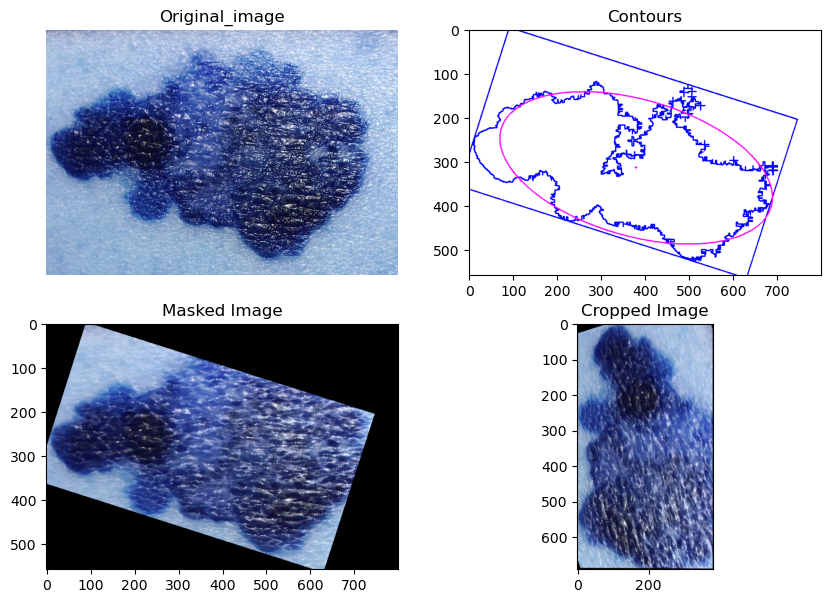

In [61]:
fig = plt.figure(figsize=[10,7])


# step1 : remove hair 
(img_ori,closing3) = step1_removehair(filename)

# step2: binarization
img_bin = step2_binary(closing3)


plt.subplot(2,2,1)
plt.title("Original_image")
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.imshow(img_ori)


# step3: locate center point
path_values_0 = []
path_values_1 = []
path_values_2 = []
path_values_3 = []
path_0 = []
path_1 = []
path_2 = []
path_3 = []
step0_direction(img_bin,path_values_0,path_0,0)
step0_direction(img_bin,path_values_1,path_1,1)
step0_direction(img_bin,path_values_2,path_2,2)
step0_direction(img_bin,path_values_3,path_3,3)

step0_findpoint(path_values_0)

if step0_findpoint(path_values_0)>0 and\
    step0_findpoint(path_values_1)>0 and\
    step0_findpoint(path_values_2)>0 and\
    step0_findpoint(path_values_3)>0:
    (Y1,X1) = path_0[-step0_findpoint(path_values_0)] 
    (Y3,X3) = path_3[-step0_findpoint(path_values_3)]
    (Y4,X4) = path_1[-step0_findpoint(path_values_1)] #右上
    (Y5,X5) = path_2[-step0_findpoint(path_values_2)] #左下
    closing4_1 = closing3[Y1:Y3, X1:X3]
    closing4_2 = closing3[Y4:Y5, X5:X4]
    if closing4_1.shape[0]*closing4_1.shape[1] < closing4_2.shape[0]*closing4_2.shape[1]:
        closing3 = closing4_1
    else:
        closing3 = closing4_2


img_bin = step2_binary(closing3)

# step4: Morphological Opening

opening3 = step3_fill(img_bin)

# step 5: return the number of the contours and the image of contours  
(max_con,l_im) = step4_contour(img_ori,opening3)

# step 6: draw the smallest ellipse and rectangle 
(area_rect,box,img_copy)=step5_rec(max_con,l_im)
(area_ell,img_copy)=step6_ell(l_im,img_copy)


plt.subplot(2,2,2)
plt.title("Contours")
plt.imshow(img_copy)

# step 7: calculate area features
(area_m,ae_diff,ar_diff) = step7_area_m(l_im,area_ell,area_rect)
area_sp = step8_area_img(img_ori)
Proportion = step9_prop(area_m,area_sp)

print("---------------Irregularity Features--------------")
print('Rectangle Area(矩形面積):', area_rect)
print('Ellipse Area(橢圓面積):', area_ell)
print('Measuring the symptoms area percentage in the original picture (瘤在圖片中的占比):', Proportion)


# step 8: mask(遮罩) the image
masked_image = step10_mask(closing3,box)
angle = step11_angle( box[0][0],  box[0][1],  box[1][0],  box[1][1])

plt.subplot(2,2,3)
plt.title("Masked Image")
plt.imshow(masked_image)



#rotated = step12_rotate(masked_image,angle)
#rotated_img_bin = step12_rotate(img_bin,angle)

# step 9: rotate the image
rotated = imutils.rotate_bound(masked_image, angle-90)
rotated_img_bin = imutils.rotate_bound((img_bin*255).astype(np.uint8), angle-90)
# plt.imshow(crop_img_bin)
crop_img, crop_img_bin = step17_newcut(rotated,rotated_img_bin)

print("---------------Asymmetry Features--------------")
print(f"Asymmetry (不對稱性): {symmetry(crop_img)}")

plt.subplot(2,2,4)
plt.title("Cropped Image")
plt.imshow(crop_img)


# step 10: measure texture(紋理) features 
(contrast,dissimilarity,homogeneity,energy,correlation) = step16_glcm(crop_img)

print("---------------Texture Features---------------")
print("Contrast(對比): {}".format(contrast))
print("Dissimilarity(差異性): {}".format(dissimilarity))
print("Homogeneity(同質性): {}".format(homogeneity))
print("Energy(能量): {}".format(energy))
print("Correlation(相關性): {}".format(correlation))



stathsv = step15_color_hsv(crop_img)
statrgb = step15_color_rgb(crop_img)

print("---------------Color Features---------------")

h_mean = stathsv[0]
s_mean = stathsv[1]
v_mean = stathsv[2]
h_std = stathsv[3]
s_std = stathsv[4]
v_std = stathsv[5]
h_skw = stathsv[6]
s_skw = stathsv[7]
v_skw = stathsv[8]

r_mean = statrgb[0]
g_mean = statrgb[1]
b_mean = statrgb[2]
r_std = statrgb[3]
g_std = statrgb[4]
b_std = statrgb[5]
r_skw = statrgb[6]
g_skw = statrgb[7]
b_skw = statrgb[8]

print("Hue average value(色相平均值): {}".format(h_mean))
print("Hue standard deviation(色相標準差): {}".format(h_std))
print("Hue skewness(色相偏度): {}".format(h_skw))

print("Saturation average value(飽和度平均值): {}".format(s_mean))
print("Saturation standard deviation(飽和度標準差): {}".format(s_std))
print("Saturation skewness(飽和度偏度): {}".format(s_skw))

print("Brightness average value(明度平均值): {}".format(v_mean))
print("Brightness standard deviation(明度標準差): {}".format(v_std))
print("Brightness skewness(明度偏度): {}".format(v_skw))


print("Red average value(紅色通道平均值): {}".format(r_mean))
print("Red standard deviation(紅色通道標準差): {}".format(r_std))
print("Red skewness(紅色通道偏度): {}".format(r_skw))

print("Green average value(綠色通道平均值): {}".format(g_mean))
print("Green standard deviation(綠色通道標準差): {}".format(g_std))
print("Green skewness(綠色通道偏度): {}".format(g_skw))

print("Blue average value(藍色通道平均值): {}".format(b_mean))
print("Blue standard deviation(藍色通道標準差): {}".format(b_std))
print("Blue skewness(藍色通道偏度): {}".format(b_skw))

plt.show()
